# MAIN IDEA

The main point is to understand if the response if _unversal_ and the chemistry only contributesto a _form factor_, or if the response is _specific_ to the chemistry.

To do se we wat to look a a couple of plots for many seeds:

1. $\max(\hat{c}(\omega))$ 
2. $\arg(\hat{c}(\omega))$ 

where $\hat{c}(\omega)$ is the Fourier transform of the average concentration $c(t)$ and $\omega$ is the driving frequency.

Hopefully, we find

$$ \hat{c}(a, \omega) = \mathcal{F}(a) \chi(\omega)$$

where $a(x, y)$ is the chemistry and $\chi(\omega)$ is the response function.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
from ADR import ADR_params_dict
from ADR_multiprocessing import ADR_parameter_span
import sqlite_handler
from sqlite_handler import select_from_param, Connection, select_from_multiple_params

We loop on seed and on frequencies

In [4]:
N_seed = 10 # Number of seeds to test
periods = list(np.geomspace(10, 1000, 50, dtype=int))
periods = list(set(periods)) # Remove duplicates
periods.sort()


ADR_params_dict['rand_seed'] = list(range(N_seed))
ADR_params_dict['Nt'] = 1000 # Length of simulation
ADR_params_dict['N_period'] = periods # Period of wind

In [5]:
do_simulations = False
if do_simulations:  # Avoid running simulations if not needed
    ADR_parameter_span(ADR_params_dict)

In [6]:
def get_oscillation_amplitude(c):

    _fft = np.fft.fft(c)

    amplitude = np.abs(np.max(_fft[1:]))
    mean = np.mean(c)
    phase  = np.angle(_fft[np.argmax(np.abs(_fft[1:]))])

    return mean, amplitude, phase

In [13]:
dataset = []
N_t_stationary = []; c_avg = []; data_periods = []
mean, amplitude, phase = [],[],[]
for period in periods:
    with Connection('./Simulations.db') as conn:
        _r =  select_from_multiple_params(conn, ['N_period'], [period], ['N_t_stationary','c_avg', 'Nt', 'rand_seed'])
        for r in _r:
            if not r:   # If no data is found
                raise ValueError('No data found')
            N_t_stationary.append(r[0])
            c_avg.append(str(r[1]))
            data_periods.append(period)
            m, a, p = get_oscillation_amplitude(r[1][r[0]:])
            mean.append(m)
            amplitude.append(a)
            phase.append(p)
            seed = r[3]

            # We create a dictionary for each seed, cointained in another dictionary
            dataset.append({'N_t_stationary': r[0], 'c_avg': r[1], \
                'periods': period, 'mean':m, 'phase':p, 'amplitude':a, 'seed':seed})

For each seed we plot $\max(\hat{c}(\omega))$ and 2. $\arg(\hat{c}(\omega))$ 

Text(0.5, 1.0, 'Amplitude vs period')

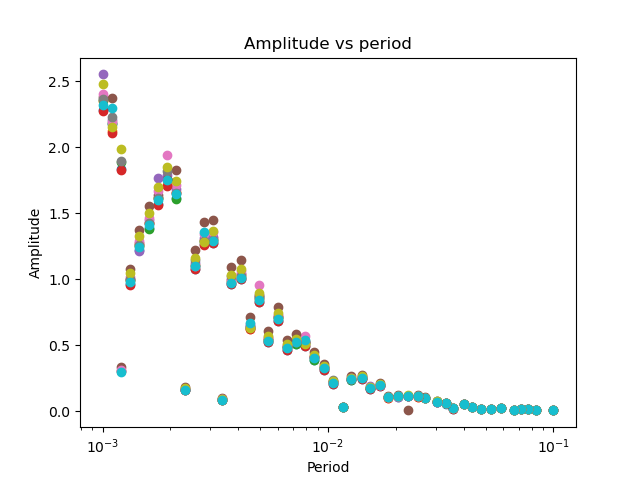

In [14]:
# Plot
plt.close('all')
plt.figure()
for params in dataset:
    plt.plot(1/params['periods'], params['amplitude'], 'o')
plt.xlabel('Period')
plt.ylabel('Amplitude')
plt.xscale('log')
plt.title('Amplitude vs period')


Text(0.5, 1.0, 'Phase vs period')

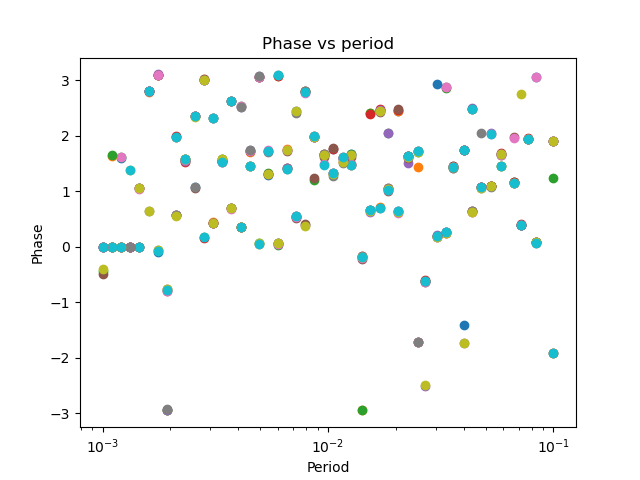

In [17]:
# Plot phase
plt.figure()
for params in dataset:
    plt.plot(1/params['periods'], params['phase'], 'o')
plt.xlabel('Period')
plt.ylabel('Phase')
plt.xscale('log')
plt.title('Phase vs period')


Text(0.5, 1.0, 'c_avg vs time')

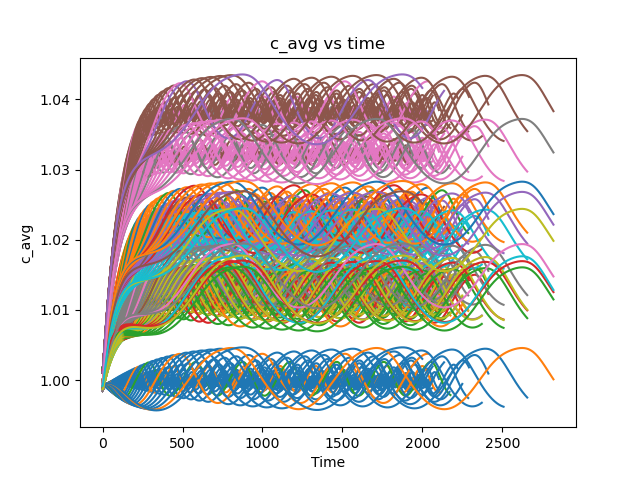

In [18]:
# Plot c_avg
plt.close('all')
plt.figure()
for params in dataset:
    plt.plot(params['c_avg'])


plt.xlabel('Time')
plt.ylabel('c_avg')
plt.title('c_avg vs time')

